# SGBDR avec PostgreSQL dans un notebook
Ce notebook est une première ébacuhe pour tester ce qu'il est possible de faire pour apprendre les bases de données relationnelles en utilisant des notebooks Jupyter.

## Modélisation 

### MEA
Un MEA peut etre réalisé simplement avec [MoCoDo](https://rawgit.com/laowantong/mocodo/master/doc/fr_refman.html).
Cet outils permet entre autres de générer à partir d'une description textuelle, le schéma, le passage vers le modèle relationnel (relations, diagramme des tables et script de création).

In [1]:
%reload_ext mocodo

Mocodo 3.1.1 loaded.


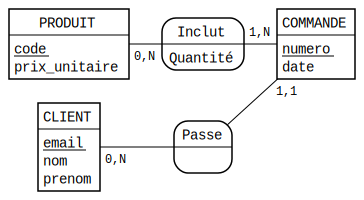

In [2]:
%%mocodo --title=client_commande --mld --relations diagram markdown_data_dict postgresql mysql oracle markdown_verbose
PRODUIT: code, prix_unitaire
Inclut, 1N COMMANDE, 0N PRODUIT: Quantité    
COMMANDE: numero, date
    
CLIENT: email, nom, prenom
Passe, 0N CLIENT, 11 COMMANDE    

In [3]:
from IPython.display import Markdown, display
display(Markdown("mocodo_notebook/sandbox_data_dict.md"))
display(Markdown("mocodo_notebook/sandbox_verbose.md"))

- email
- nom
- prenom
- numero
- date
- Quantité
- code
- prix_unitaire

**CLIENT** (<ins>email</ins>, nom, prenom)  
- Le champ _email_ constitue la clé primaire de la table. C'était déjà un identifiant de l'entité _CLIENT_.  
- Les champs _nom_ et _prenom_ étaient déjà de simples attributs de l'entité _CLIENT_.  

**COMMANDE** (<ins>numero</ins>, date, _#email_)  
- Le champ _numero_ constitue la clé primaire de la table. C'était déjà un identifiant de l'entité _COMMANDE_.  
- Le champ _date_ était déjà un simple attribut de l'entité _COMMANDE_.  
- Le champ _email_ est une clé étrangère. Il a migré par l'association de dépendance fonctionnelle _Passe_ à partir de l'entité _CLIENT_ en perdant son caractère identifiant.  

**Inclut** (<ins>_#numero_</ins>, <ins>_#code_</ins>, Quantité)  
- Le champ _numero_ fait partie de la clé primaire de la table. C'est une clé étrangère qui a migré directement à partir de l'entité _COMMANDE_.  
- Le champ _code_ fait partie de la clé primaire de la table. C'est une clé étrangère qui a migré directement à partir de l'entité _PRODUIT_.  
- Le champ _Quantité_ était déjà un simple attribut de l'association _Inclut_.  

**PRODUIT** (<ins>code</ins>, prix_unitaire)  
- Le champ _code_ constitue la clé primaire de la table. C'était déjà un identifiant de l'entité _PRODUIT_.  
- Le champ _prix_unitaire_ était déjà un simple attribut de l'entité _PRODUIT_.

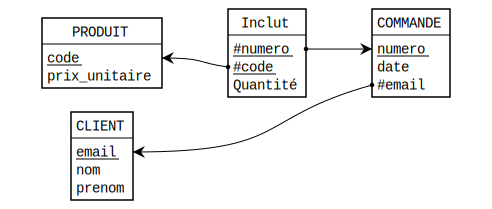

In [4]:
mocodo --input mocodo_notebook/sandbox.mld

Les scripts SQL sont disponibles pour [PostgreSQL](mocodo_notebook/sandbox_postgresql.sql), [MySQL](mocodo_notebook/sandbox_mysql.sql) et [Oracle](mocodo_notebook/sandbox_oracle.sql)..

### UML
Il est possible de construire simplement des diagrammes (dont UML) en utilisant [PlantUML](https://plantuml.com).

In [5]:
import iplantuml

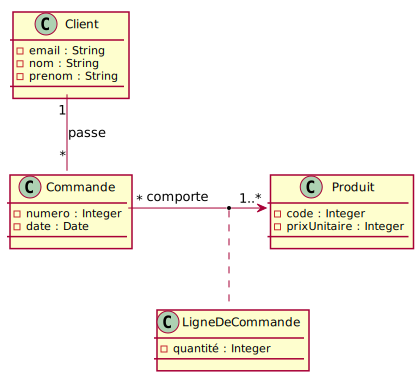

In [6]:
%%plantuml --jar
@startuml
class Commande { 
     - numero : Integer
     - date : Date 
 }
class Produit {
     - code : Integer
     - prixUnitaire : Integer
 }
class LigneDeCommande { 
     - quantité : Integer 
 }    

class Client { 
    - email : String 
    - nom : String 
    - prenom : String 
 }

Commande "*" -> "1..*" Produit  : comporte
(Commande, Produit) .. LigneDeCommande
Client "1" -- "*" Commande : passe
@enduml

## Initialisation connection SGBD
L'intégration de SQL est faite avec [ipython-sql](https://github.com/catherinedevlin/ipython-sql).


Pour commencer, il faut changer l'extension SQL pour jupyter.

In [7]:
%reload_ext sql

Le lancement du serveur PostgreSQL et création d'une base de données est automatique avant le lancement. La base de données est stockée physiqment dans le répertoire 'work/pgdata/DEMO_DB'.

L'ouverture d'une connexion à la base de données peut se faire une seule fois ou à chaque requête (il est possible d'avoir plusieurs connections différentes).

In [8]:
%sql postgresql://localhost/jovyandb

## Utilisation de SQL
L'utilisation SQL peut se faire dans une cellule en le préfixant de %%sql

In [9]:
%%sql
DROP TABLE IF EXISTS LIGNE_DE_COMMANDE;
DROP TABLE IF EXISTS COMMANDE;
DROP TABLE IF EXISTS CLIENT;
DROP TABLE IF EXISTS PRODUIT;

CREATE TABLE CLIENT (
    id_client int GENERATED ALWAYS AS IDENTITY,
    email  varchar(255) NOT NULL UNIQUE,
    nom    varchar(100) NOT NULL,
    prenom varchar(100) NOT NULL,
    PRIMARY KEY(id_client) 
);

CREATE TABLE PRODUIT (
    code_produit int GENERATED ALWAYS AS IDENTITY,
    description varchar(10),
    prix_unitaire int,
    PRIMARY KEY(code_produit)
);
    
CREATE TABLE COMMANDE (
    numero_commande int GENERATED ALWAYS AS IDENTITY,    
    date   date DEFAULT CURRENT_DATE,
    id_client int,
    PRIMARY KEY(numero_commande),
    CONSTRAINT fk_client
      FOREIGN KEY(id_client) 
      REFERENCES CLIENT(id_client)
);

CREATE TABLE LIGNE_DE_COMMANDE (
    numero_commande int,
    code_produit int,
    quantite int,
    PRIMARY KEY(numero_commande, code_produit)
);

 * postgresql://localhost/jovyandb
Done.
Done.
Done.
Done.
Done.
Done.
Done.
Done.


[]

In [10]:
%%sql
INSERT INTO CLIENT (email, nom, prenom) VALUES ('a.b@x.fr','a','b');
INSERT INTO CLIENT (email, nom, prenom) VALUES ('c.d@x.fr','c','d');
INSERT INTO CLIENT (email, nom, prenom) VALUES ('e.f@x.fr','e','f');

 * postgresql://localhost/jovyandb
1 rows affected.
1 rows affected.
1 rows affected.


[]

In [13]:
%%sql 
SELECT * FROM CLIENT

 * postgresql://localhost/jovyandb
3 rows affected.


id_client,email,nom,prenom
1,a.b@x.fr,a,b
2,c.d@x.fr,c,d
3,e.f@x.fr,e,f


Les résultats des requêtes peuvent être affecté dans des variables python et traitée sous forme de dataframes avec la librairie Panda.

In [14]:
clients = %sql  SELECT * FROM CLIENT
clients.DataFrame().info()

 * postgresql://localhost/jovyandb
3 rows affected.


ModuleNotFoundError: No module named 'pandas'

In [15]:
%%sql
INSERT INTO PRODUIT (description, prix_unitaire) VALUES ('pomme',2);
INSERT INTO PRODUIT (description, prix_unitaire) VALUES ('peche',4);
INSERT INTO PRODUIT (description, prix_unitaire) VALUES ('poire',3);

 * postgresql://localhost/jovyandb
1 rows affected.
1 rows affected.
1 rows affected.


[]

In [16]:
%%sql 
SELECT * FROM PRODUIT

 * postgresql://localhost/jovyandb
3 rows affected.


code_produit,description,prix_unitaire
1,pomme,2
2,peche,4
3,poire,3


In [17]:
insert_command_result=%sql INSERT INTO COMMANDE (id_client) VALUES (1) RETURNING numero_commande;
numero_commande=insert_command_result[0][0]

 * postgresql://localhost/jovyandb
1 rows affected.


Il est aussi possible d'utiliser des variables python comme paramètres des requêtes.

In [18]:
%%sql
INSERT INTO LIGNE_DE_COMMANDE VALUES ({numero_commande}, 1,5);
INSERT INTO LIGNE_DE_COMMANDE VALUES ({numero_commande}, 2,2);
INSERT INTO LIGNE_DE_COMMANDE VALUES ({numero_commande}, 3,1);

SELECT * FROM LIGNE_DE_COMMANDE;

 * postgresql://localhost/jovyandb
1 rows affected.
1 rows affected.
1 rows affected.
3 rows affected.


numero_commande,code_produit,quantite
1,1,5
1,2,2
1,3,1


Et donc de les afficher très simple y compris sous forme graphique.

In [19]:
result = %sql select * from PRODUIT;  
produits_dataframe = result.DataFrame()
produits_dataframe.set_index('description')[["prix_unitaire"]].plot.bar(rot=0)

 * postgresql://localhost/jovyandb
3 rows affected.


ModuleNotFoundError: No module named 'pandas'